In [64]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from v3_properties import *
import ipywidgets as widgets
from ipywidgets import interact

In [65]:
# Read Data
model = 'v3'
year = '2019'
month = '10'
day = '08'

if model == 'v3':
    from v3_properties import *
elif model == 'v9':
    from v9_properties import *

path = './results/'+model+'/'
file_name = model+'_'+year+'-'+month+'-'+day

results = pd.read_csv(path+file_name+'_res_va.csv')
flight_data = pd.read_csv(path+file_name+'_fd_va.csv')

x = results.x
y = results.y
z = results.z
vx = results.vx
vy = results.vy
vz = results.vz
uf = results.uf
wdir = results.wdir
CL = results.CL
CD = results.CD
CS = results.CS
CL = np.sqrt(CL**2+CS**2)
CLw = results.CLw
CDw = results.CDw
aoa = results.aoa
pitch = results.pitch
roll = results.roll
yaw = results.yaw
yaw = np.arccos(np.cos((yaw-180)/180*np.pi))*180/np.pi

wvel = uf/kappa*np.log(z/z0)
vw = np.vstack((wvel*np.cos(wdir),wvel*np.sin(wdir),np.zeros(len(wvel)))).T
wvel = np.linalg.norm(vw,axis=1)
wdir = wdir*180/np.pi
v = np.vstack((np.array(vx),np.array(vy),np.array(vz))).T
va = vw-v
va_mod = np.linalg.norm(va,axis = 1)

time = flight_data.time - flight_data['time'].iloc[0]
measured_aoa = flight_data['airspeed_angle_of_attack']
measured_va = flight_data['airspeed_apparent_windspeed']
meas_course = flight_data['kite_course']
meas_pitch = flight_data['pitch0']-5
meas_pitch1 = flight_data['pitch1']-5
meas_roll = flight_data['roll0']-5
meas_roll1 = flight_data['roll1']-5
meas_yaw = flight_data['yaw0']
# meas_yaw = np.arccos(np.cos(meas_yaw/180*np.pi))*180/np.pi
meas_yaw1 = flight_data['yaw1']
# meas_yaw1 = np.arccos(np.cos(meas_yaw1/180*np.pi))*180/np.pi
measured_wdir = -flight_data['ground_upwind_direction']-90+360
measured_wvel = flight_data['ground_wind_velocity']


turn = (flight_data['ground_tether_reelout_speed'] > 0) & (abs(flight_data['kite_set_steering']) > 30)
straight = (flight_data['ground_tether_reelout_speed'] > 0) & (abs(flight_data['kite_set_steering']) < 30)
dep = (flight_data['ground_tether_reelout_speed'] < 0) & (flight_data['kite_set_depower'] > 23)
trans = (flight_data['ground_tether_reelout_speed'] < 0) & (flight_data['kite_set_depower'] < 23)
pow = (flight_data['ground_tether_reelout_speed'] > 0) & (flight_data['kite_set_depower'] < 23)
turn_right = (flight_data['ground_tether_reelout_speed'] > 0) & (abs(flight_data['kite_set_steering']) > 10) & (np.gradient(flight_data['kite_course'])<0 )
turn_left = (flight_data['ground_tether_reelout_speed'] > 0) & (abs(flight_data['kite_set_steering']) > 10) & (np.gradient(flight_data['kite_course'])>0 )


In [66]:
# Plot aerodynamic coefficients, aoa, va

def update_plots(time_shift, time_range):
    selected_time = time + time_shift
    mask = (time >= time_shift) & (time <= (time_shift + time_range))
    
    colors = ['lightblue', 'lightgreen', 'lightcoral', (0.75, 0.6, 0.8)]

    fig, axs = plt.subplots(4, 1, figsize=(10, 15), sharex=True)

    for ax in axs:
        ax.grid()
    axs[0].fill_between(time[mask], CLw[mask], where=straight[mask], color=colors[0], alpha=0.2)
    axs[0].fill_between(time[mask], CLw[mask], where=turn[mask], color=colors[1], alpha=0.2)
    axs[0].fill_between(time[mask], CLw[mask], where=dep[mask], color=colors[2], alpha=0.2)
    axs[0].fill_between(time[mask], CLw[mask], where=trans[mask], color=colors[3], alpha=0.2)
    axs[0].plot(time[mask], CLw[mask], label='Quasi-steady tether model')
    axs[0].plot(time[mask], CL[mask], label='IEKF')
    axs[0].set_ylabel('CL')

    axs[1].plot(time[mask], CDw[mask], label='Quasi-steady tether model')
    axs[1].plot(time[mask], CD[mask], label='IEKF')
    axs[1].fill_between(time[mask], CDw[mask], where=straight[mask], color=colors[0], alpha=0.2)
    axs[1].fill_between(time[mask], CDw[mask], where=turn[mask], color=colors[1], alpha=0.2)
    axs[1].fill_between(time[mask], CDw[mask], where=dep[mask], color=colors[2], alpha=0.2)
    axs[1].fill_between(time[mask], CDw[mask], where=trans[mask], color=colors[3], alpha=0.2)
    axs[1].set_ylabel('CD')

    axs[2].plot(time[mask], aoa[mask], label='Sim. aoa')
    axs[2].plot(time[mask], measured_aoa[mask] - 3, label='Meas. aoa')
    axs[2].fill_between(time[mask], aoa[mask], where=straight[mask], color=colors[0], alpha=0.2)
    axs[2].fill_between(time[mask], aoa[mask], where=turn[mask], color=colors[1], alpha=0.2)
    axs[2].fill_between(time[mask], aoa[mask], where=dep[mask], color=colors[2], alpha=0.2)
    axs[2].fill_between(time[mask], aoa[mask], where=trans[mask], color=colors[3], alpha=0.2)
    axs[2].set_ylabel('AOA')

    axs[3].plot(time[mask], va_mod[mask], label='Sim. va')
    axs[3].plot(time[mask], measured_va[mask], label='Meas. va')
    axs[3].fill_between(time[mask], va_mod[mask], where=straight[mask], color=colors[0], alpha=0.2)
    axs[3].fill_between(time[mask], va_mod[mask], where=turn[mask], color=colors[1], alpha=0.2)
    axs[3].fill_between(time[mask], va_mod[mask], where=dep[mask], color=colors[2], alpha=0.2)
    axs[3].fill_between(time[mask], va_mod[mask], where=trans[mask], color=colors[3], alpha=0.2)
    axs[3].set_xlabel('Time')
    axs[3].set_ylabel('Velocity')

    # Create a single legend outside the subplots
    fig.legend(labels=['Powered straight', 'Powered turn', 'Depowered', 'Transition' ], loc='right')
    plt.tight_layout()
    
    plt.show()

time_shift_slider = widgets.FloatSlider(
    value=1400, min=0, max=time.iloc[-1], step=10, description='Time Shift', continuous_update=False
)
time_shift_slider.layout.width = '100%'  # You can adjust the percentage as needed
time_range_slider = widgets.FloatSlider(
    value=140, min=10, max=1500, step=10, description='Time Range', continuous_update=False
)
time_range_slider.layout.width = '50%'  # You can adjust the percentage as needed
interactive_plot = interact(update_plots, time_shift=time_shift_slider, time_range=time_range_slider)

interactive(children=(FloatSlider(value=1400.0, continuous_update=False, description='Time Shift', layout=Layo…

In [67]:
## Plot Wind Direction and CL CD
angle = []
az = flight_data['kite_azimuth']*180/np.pi
meas_Ft = flight_data['ground_tether_force']
# meas_heading = flight_data['kite_heading']
# meas_course = flight_data['kite_course']
mean_az = np.mean(az)

windir = wdir

CL_right = np.mean(CLw[turn_right])
CL_left = np.mean(CLw[turn_left])

print('Mean CL right turns: ', CL_right)
print('Mean CL left turns: ', CL_left)
def update_plots(time_shift, time_range):
    selected_time = time + time_shift
    mask = (time >= time_shift) & (time <= (time_shift + time_range))
    colors = ['lightblue', 'lightgreen', 'lightcoral', (0.75, 0.6, 0.8)]

    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    for ax in axs:
        ax.grid()

    axs[1].fill_between(time[mask], az[mask], where=turn_right[mask], color=colors[1], alpha=0.2)
    axs[1].fill_between(time[mask], az[mask], where=turn_left[mask], color=colors[0], alpha=0.2)
    axs[1].plot(time[mask], az[mask], label='Azimuth')
    axs[1].plot(time[mask], windir[mask], label='Wind direction')
    axs[1].set_ylabel('Azimuth')
    axs[1].legend()

    axs[0].fill_between(time[mask], CLw[mask], where=turn_left[mask], color=colors[0], alpha=0.2)
    axs[0].fill_between(time[mask], CLw[mask], where=turn_right[mask], color=colors[1], alpha=0.2)
    axs[0].plot(time[mask], CLw[mask], label='CL')
    axs[0].plot(time[mask], CDw[mask], label='CD')
    axs[0].set_ylabel('Aero coeffs.')
    axs[0].legend()

    middle_time = (time_shift + time_shift + time_range) / 2
    CL_right = np.mean(CLw[mask&turn_right])
    CD_right = np.mean(CDw[mask&turn_right])
    CL_left = np.mean(CLw[mask&turn_left])
    CD_left = np.mean(CDw[mask&turn_left])
    axs[0].text(middle_time, 0.41, f'Right turn mean: CL = {CL_right:.2f} CD = {CD_right:.2f}\n Right turn mean: CL = {CL_left:.2f} CD = {CD_left:.2f}', ha='center', va='center', fontsize=12)
    
    # Create a single legend outside the subplots
    fig.legend(labels=['Left turn', 'Right turn' ], loc='upper left')
    plt.tight_layout()
    plt.show()

time_shift_slider = widgets.FloatSlider(
    value=1400, min=0, max=time.iloc[-1], step=10, description='Time Shift', continuous_update=False
)
time_shift_slider.layout.width = '100%'  # You can adjust the percentage as needed
time_range_slider = widgets.FloatSlider(
    value=140, min=10, max=time.iloc[-1], step=10, description='Time Range', continuous_update=False
)
time_range_slider.layout.width = '50%'  # You can adjust the percentage as needed
interactive_plot = interact(update_plots, time_shift=time_shift_slider, time_range=time_range_slider)

Mean CL right turns:  0.6284515184817383
Mean CL left turns:  0.626760471963497


interactive(children=(FloatSlider(value=1400.0, continuous_update=False, description='Time Shift', layout=Layo…

87


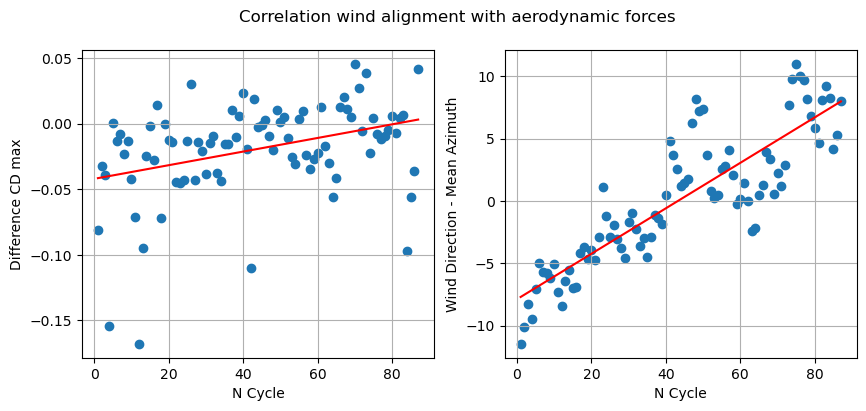

0.39569026379221145


In [68]:
### ASSYMETRY in Forces

t_start = 0
new_cycle = True
CL_right = []
CD_right = []
CL_left = []
CD_left = []
mean_az = []
mean_wdir = []
count = 0
for i in range(len(time)):
    if dep[i] and new_cycle:
        mask = (time >= t_start) & (time <= time[i])
        CL_right.append(np.max(CLw[mask&turn_right]))
        CD_right.append(np.max(CDw[mask&turn_right]))
        CL_left.append(np.max(CLw[mask&turn_left]))
        CD_left.append(np.max(CDw[mask&turn_left]))
        mean_az.append(np.mean(az[mask&pow]))
        mean_wdir.append(np.mean(windir[mask&pow]))
        new_cycle = False
    if pow[i] and not new_cycle:
        t_start = time[i]
        new_cycle = True
        count +=1

cycles = np.arange(1,count+1)
CDdiff = -np.array(CD_right)+np.array(CD_left)
dirdiff = np.array(mean_az)-np.array(mean_wdir)
coefficients = np.polyfit(cycles, CDdiff, 1)
polynomial = np.poly1d(coefficients)
CLdiff_fit = polynomial(cycles)  # Calculate Cl values for the trendline
coefficients = np.polyfit(cycles, dirdiff, 1)
polynomial = np.poly1d(coefficients)
dirdiff_fit = polynomial(cycles)  # Calculate Cl values for the trendline
print(count)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for ax in axs:
        ax.grid()
axs[0].scatter(cycles,CDdiff)
axs[0].plot(cycles,CLdiff_fit,'r')
axs[0].set_ylabel('Difference CD max')
axs[0].set_xlabel('N Cycle')

axs[1].scatter(cycles,dirdiff)
axs[1].plot(cycles,dirdiff_fit,'r')
axs[1].set_ylabel('Wind Direction - Mean Azimuth')
axs[1].set_xlabel('N Cycle')
# Set the title for the entire figure
fig.suptitle('Correlation wind alignment with aerodynamic forces')

plt.show()

correlation_matrix = np.corrcoef(CDdiff,dirdiff)
correlation_coefficient = correlation_matrix[0, 1]
print(correlation_coefficient)

In [69]:
# Plot Euler Angles
def update_plots(time_shift, time_range):
    selected_time = time + time_shift
    mask = (time >= time_shift) & (time <= (time_shift + time_range))
    colors = ['lightblue', 'lightgreen', 'lightcoral', (0.75, 0.6, 0.8)]

    fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

    for ax in axs:
        ax.grid()

    axs[0].fill_between(time[mask], pitch[mask], where=straight[mask], color=colors[0], alpha=0.2)
    axs[0].fill_between(time[mask], pitch[mask], where=turn[mask], color=colors[1], alpha=0.2)
    axs[0].fill_between(time[mask], pitch[mask], where=dep[mask], color=colors[2], alpha=0.2)
    axs[0].fill_between(time[mask], pitch[mask], where=trans[mask], color=colors[3], alpha=0.2)
    axs[0].plot(time[mask], pitch[mask]-90, label='Simulated')
    axs[0].plot(time[mask], meas_pitch[mask], label='Measured')
    axs[0].plot(time[mask], meas_pitch1[mask], label='Measured')
    axs[0].set_ylabel('Pitch')
    axs[0].legend()

    axs[1].plot(time[mask], roll[mask]-90, label='Simulated')
    axs[1].plot(time[mask], meas_roll[mask], label='Measured')
    axs[1].plot(time[mask], meas_roll1[mask], label='Measured')
    axs[1].fill_between(time[mask], roll[mask], where=straight[mask], color=colors[0], alpha=0.2)
    axs[1].fill_between(time[mask], roll[mask], where=turn[mask], color=colors[1], alpha=0.2)
    axs[1].fill_between(time[mask], roll[mask], where=dep[mask], color=colors[2], alpha=0.2)
    axs[1].fill_between(time[mask], roll[mask], where=trans[mask], color=colors[3], alpha=0.2)
    axs[1].set_ylabel('Roll')
    axs[1].legend()


    
    axs[2].plot(time[mask], yaw[mask], label='Simulated')
    axs[2].plot(time[mask], meas_yaw[mask], label='Measured')
    axs[2].plot(time[mask], meas_yaw1[mask], label='Measured')
    axs[2].fill_between(time[mask], yaw[mask], where=straight[mask], color=colors[0], alpha=0.2)
    axs[2].fill_between(time[mask], yaw[mask], where=turn[mask], color=colors[1], alpha=0.2)
    axs[2].fill_between(time[mask], yaw[mask], where=dep[mask], color=colors[2], alpha=0.2)
    axs[2].fill_between(time[mask], yaw[mask], where=trans[mask], color=colors[3], alpha=0.2)
    axs[2].set_ylabel('Yaw')
    axs[2].legend()

    # Create a single legend outside the subplots
    fig.legend(labels=['Powered straight', 'Powered turn', 'Depowered', 'Transition' ], loc='right')
    plt.tight_layout()
    
    plt.show()

time_shift_slider = widgets.FloatSlider(
    value=1400, min=0, max=time.iloc[-1], step=10, description='Time Shift', continuous_update=False
)
time_shift_slider.layout.width = '100%'  # You can adjust the percentage as needed
time_range_slider = widgets.FloatSlider(
    value=140, min=10, max=300, step=10, description='Time Range', continuous_update=False
)
time_range_slider.layout.width = '50%'  # You can adjust the percentage as needed
interactive_plot = interact(update_plots, time_shift=time_shift_slider, time_range=time_range_slider)

interactive(children=(FloatSlider(value=1400.0, continuous_update=False, description='Time Shift', layout=Layo…

In [70]:
# Plot wind direction and velocity with ERA5 data

start = 4000
end = start+36000
hours = [13,14,15]

h_ticks = np.arange(0,350,50)
heights = np.arange(100, 301, step=50)
ground_wdir = measured_wdir[start:end]
ground_wvel = measured_wvel[start:end]
mindir = []
maxdir = []
minvel = []
maxvel = []

fig_vel, ax_vel = plt.subplots(1, 3, sharey=True, figsize=(12, 4))
fig_dir, ax_dir = plt.subplots(1, 3, sharey=True, figsize=(12, 4))
for i in range(len(hours)):
    ERA5vel = np.loadtxt('data/'+str(hours[i])+'hwindvel.csv',delimiter = ',')    
    hERA5 = ERA5vel[0:-1:2,1]
    minERA5 = ERA5vel[0:-1:2,0]
    maxERA5 = ERA5vel[1::2,0]
    ax_vel[i].fill_betweenx(hERA5, minERA5, maxERA5, color='lightgrey', alpha=0.5)
    ax_vel[i].scatter(wvel[start:end],z[start:end],color = 'lightblue',alpha = 0.5)
    ax_vel[i].boxplot([measured_wvel[start:end]],positions = [10],vert = False,widths=(20))
    ax_vel[i].set_title(str(hours[i])+'h')
    ax_vel[i].set_xlabel('Wind velocity')
    ax_vel[i].set_yticks(h_ticks)
    ax_vel[i].set_yticklabels(h_ticks)
    ax_vel[i].grid()
    
    
    ERA5dir = np.loadtxt('data/'+str(hours[i])+'hwinddir.csv',delimiter = ',')
    hERA5 = ERA5dir[0:-1:2,1]
    minERA5 = ERA5dir[0:-1:2,0]
    maxERA5 = ERA5dir[1::2,0]
    ax_dir[i].fill_betweenx(hERA5, minERA5, maxERA5, color='lightgrey', alpha=0.5)
    ax_dir[i].scatter(wdir[start:end],z[start:end],color = 'lightblue',alpha = 0.5)
    ax_dir[i].boxplot([measured_wdir[start:end]],positions = [10],vert = False,widths=(20))
    ax_dir[i].set_title(str(hours[i])+'h')
    ax_dir[i].set_xlabel('Wind direction')
    ax_dir[i].set_yticks(h_ticks)
    ax_dir[i].set_yticklabels(h_ticks)
    ax_dir[i].grid()
    
    
    if i == 0:
        ax_dir[i].set_ylabel('Height')
        ax_vel[i].set_ylabel('Height')
    start = end
    end = start+36000

In [ ]:
# Plot wind speed and direction
def update_plots(time_shift, time_range):
    selected_time = time + time_shift
    mask = (time >= time_shift) & (time <= (time_shift + time_range))
    colors = ['lightblue', 'lightgreen', 'lightcoral', (0.75, 0.6, 0.8)]

    fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

    for ax in axs:
        ax.grid()

    # axs[0].fill_between(time[mask], wvel[mask], where=straight[mask], color=colors[0], alpha=0.2)
    # axs[0].fill_between(time[mask], wvel[mask], where=turn[mask], color=colors[1], alpha=0.2)
    # axs[0].fill_between(time[mask], wvel[mask], where=dep[mask], color=colors[2], alpha=0.2)
    # axs[0].fill_between(time[mask], wvel[mask], where=trans[mask], color=colors[3], alpha=0.2)
    axs[0].plot(time[mask], wvel[mask], label='Simulated')
    axs[0].set_ylabel('Horizontal wind speed')
    axs[0].legend()

    axs[1].plot(time[mask], uf[mask], label='Simulated')
    axs[1].set_ylabel('Friction velocity')
    axs[1].legend()
    
    axs[2].plot(time[mask], wdir[mask], label='Simulated')
    axs[2].fill_between(time[mask], wdir[mask], where=straight[mask], color=colors[0], alpha=0.2)
    axs[2].fill_between(time[mask], wdir[mask], where=turn[mask], color=colors[1], alpha=0.2)
    axs[2].fill_between(time[mask], wdir[mask], where=dep[mask], color=colors[2], alpha=0.2)
    axs[2].fill_between(time[mask], wdir[mask], where=trans[mask], color=colors[3], alpha=0.2)
    axs[2].set_ylabel('Wind direction')
    axs[2].legend()

    # Create a single legend outside the subplots
    fig.legend(labels=['Powered straight', 'Powered turn', 'Depowered', 'Transition' ], loc='right')
    plt.tight_layout()
    
    plt.show()

time_shift_slider = widgets.FloatSlider(
    value=0, min=0, max=time.iloc[-1], step=10, description='Time Shift', continuous_update=False
)
time_shift_slider.layout.width = '100%'  # You can adjust the percentage as needed
time_range_slider = widgets.FloatSlider(
    value=140, min=10, max=time.iloc[-1], step=10, description='Time Range', continuous_update=False
)
time_range_slider.layout.width = '50%'  # You can adjust the percentage as needed
interactive_plot = interact(update_plots, time_shift=time_shift_slider, time_range=time_range_slider)

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='Time Shift', layout=Layout(…